In [ ]:
import numpy as np
import pandas as pd
import random
import torch
from matplotlib import pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import plotly
import plotly.graph_objs as go

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [ ]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [ ]:
import collections

In [ ]:
!pip install yfinance
clear_output()
import yfinance as yf

In [ ]:
df = yf.download(tickers='TSLA')
df = df[-1000:]
df = df.reset_index(drop=True)
print(df.head())

[*********************100%%**********************]  1 of 1 completed

         Open        High         Low       Close   Adj Close     Volume
0  159.663330  159.679993  135.039993  149.123337  149.123337  288528300
1  135.743332  143.933334  134.000000  135.666672  135.666672  262788300
2  134.270004  142.666672  124.006668  139.440002  139.440002  330965700
3  118.666664  122.913330  109.959999  110.070000  110.070000  346397100
4  118.866669  123.000000  113.836670  122.093330  122.093330  238397400


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = df['Close'][:],
    line =  dict(shape =  'spline' ),
    name = 'Курс акции TSLA'
            ))
fig.show()

In [ ]:
df['Close']

,Close
0,149.123337
1,135.666672
2,139.440002
3,110.070000
4,122.093330
...,...
995,222.720001
996,221.100006
997,223.270004
998,210.660004


In [ ]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет
        происходить дальнейшее обучение
    '''
    def __init__(self, train_data, test_data, normalize = True, noise = True):
        self.train_length = train_data.shape[0]
        self.test_length = test_data.shape[0]
        self.data = np.concatenate([train_data.flatten(), test_data.flatten()])


        if noise:
            # Подаем шум для данных от 0.1 до 1
            self.data += np.random.normal(0, 0.1, size = self.data.shape)
        if normalize:
            # Нормализация после данных после шума
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        Возвращаем производные отдельного окна в нашей выборке
        и убираем нули в начале
        """
        window = self.data[time-lookback:time]
        if diff: window = np.diff(window, prepend = window.flatten()[0])
        return window

    def get_reward(self, action, action_time, reward_time, coef = 100):
        """
        Основная логика получения награды
        0 => long 1 => hold 2 => short
        """
        if action == 0:
            action = -1
        # print(23, self.data)
        # Вытаскиваем текущую цену
        price_now = self.data[action_time]
        # Вытаскиваем следующую цену
        price_reward = self.data[reward_time]
        # Получаем разницу в проценте
        price_diff = (price_reward - price_now) / price_now
        # Прибавляем к портфелю следующее число:
        # Дельта изменения валюты * покупку/продажу/холд * коэф. закупки
        reward = price_diff * action * coef
        # print(12121, reward)
        return reward

In [ ]:
# Обратите внимание на то, что в RL часто используются совсем простые нейронные сети
class Net(nn.Module):
    """Строим простую модель нейронки"""
    def __init__(self, state_shape, action_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_shape, 50)
        self.fc2 = nn.Linear(50, action_shape)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.drop(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
class BuyHoldSellAgent:
    '''
        Агент для покупки продажи
    '''
    def __init__(self, state_shape = 10, action_shape = 2, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.experience = collections.deque(maxlen=self.experience_size)

        # Создадим экземпляр модели
        self.model = Net(state_shape, action_shape)

        # Создадим функцию ошибки
        self.criterion = nn.L1Loss()
        # Добавим оптимизатор
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.001)

    def save_experience(self, current_state, action, reward, next_state):
        """Метод для сохранения предудыщих данных эксперимента"""
        self.experience.append({
            'state_i': current_state,
            'action_i': action,
            'reward_i': reward,
            'state_i_1': next_state
        })

    def replay_experience(self, gamma, sample_size):
        """Метод для оптимизации данных тренировки"""
        # Создаем фиксированную выборку из добавленных событий
        indices_sampled = np.random.choice(
            len(self.experience),
            sample_size,
            replace=False
        )
        # Проходимся только по тем элементам, которые были добавлены в выборку

        current_states = []
        actions = []
        rewards = []
        next_states = []
        for i in indices_sampled:
            state_i, action_i, reward_i, state_i_1 = self.experience[i]['state_i'], self.experience[i]['action_i'], self.experience[i]['reward_i'], self.experience[i]['state_i_1']
            current_states.append(state_i)
            actions.append(action_i)
            rewards.append(reward_i)
            next_states.append(state_i_1)

        current_states = np.array(current_states).squeeze()
        next_states = np.array(next_states).squeeze()

        # Получаем прогноз по следующему состоянию
        next_q_values = self.model(torch.from_numpy(next_states).float()).detach().numpy()

        # Получаем прогноз по текущему состоянию
        current_q_values = self.model(torch.from_numpy(current_states).float()).detach().numpy()
        # Уравнение Бэллмена
        # Суть в том, что мы берем максимально возможную награду
        # из действия из будущего шага (q_value_i_1) , умножаем ее на гамму
        # (коэф. значимости будущих наград), прибавляем к текущей награде
        for i in range(len(indices_sampled)):
            # и заносим в Q таблицу для обучения
            current_q_values[i, actions[i]] = rewards[i] + gamma * next_q_values[i, :].max()

        outputs = self.model(torch.from_numpy(np.expand_dims(current_states.reshape(-1, WINDOW_SHAPE), 0)).float())[0]
        loss = self.criterion(outputs, torch.Tensor(current_q_values))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_value_action_value(self, state):
        """Метод для прогноза сигнала"""
        state = np.expand_dims(state, axis = 0)
        pred = self.model(torch.from_numpy(state).float())
        return pred.flatten()

In [ ]:
# Количество эпох обучения
epochs = 500
# Коэф. значимости награды на шаг вперед
gamma = 0.99
# Количество эпох обучения
epsilon = 0.95

In [ ]:
# Размер датасета
DATASET_LENGTH = len(df['Close'])
# Размер окна из которого будут браться предыдущие данные
WINDOW_SHAPE = 30
# Шаг предыдущих данных
REWARD_TIME = 1
# Число доступных действий
ACTIONS_SHAPE = 2
# Размер выборки
SAMPLE_SIZE = 30


In [ ]:
action_to_backtest_action = {
    1: 1,  # покупаем
    0: -1,  # продаем
}

In [ ]:
train_dataset = np.array(df['Close'][:-100])
test_dataset = np.array(df['Close'][-100:])

In [ ]:
# Прописываем новую среду и передаем данные о закрытии цены
environment = Environment(train_dataset, test_dataset, normalize = False, noise = False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE)

In [ ]:
set_random_seed(42)


for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, environment.train_length - REWARD_TIME, REWARD_TIME):
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Получаем текущее состояние. Производные в отдельном интервале
        # Текущий Y на графике и предыдущие WINDOW_SHAPE шагов
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # Получаем предсказание по данному состоянию через модель
        q_value_j = agent.get_value_action_value(state_j)

        # 2. Выбираем действие для текущего состояния
        # В зависимости от длины эпсилона, выбираем случайное действие
        # или реальные по предсказаниям
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = np.argmax(q_value_j.detach().numpy())

        # 3. Получаем награду за выбранное действие
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. Получаем будущее состояние. Производные в будущем интервале
        # Текущий Y + 1 на графике и предыдущие WINDOW_SHAPE шагов
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. Сохраняем все полученные данные в агента
        agent.save_experience(state_j, action, reward_value_j, state_j_1)

        # 6. Как только число ранее полученных сэмплов перевалило
        # за необходимое, начинаем тренировать сеть
        if j > SAMPLE_SIZE * 2:
            agent.replay_experience(gamma, SAMPLE_SIZE)

    # С каждым шагом уменьшаем эпсилон, чтобы бот начинал действовать
    # по собственным прогнозам и переставал изучать среду
    epsilon = 1.0 / (i+1)

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

Epoch 0 ... 0.1158581515922227
Epoch 1 ... 0.04936898557341691
Epoch 2 ... 0.21097825239782722
Epoch 3 ... 0.464177296893606
Epoch 4 ... 0.33342033248934766
Epoch 5 ... 0.2769168536277423
Epoch 6 ... 0.3501842444999004
Epoch 7 ... 0.4498483514807066
Epoch 8 ... 0.4343056823516845
Epoch 9 ... 0.36752867381266957
Epoch 10 ... 0.3044498667579546
Epoch 11 ... 0.296811622636859
Epoch 12 ... 0.3944194906593017
Epoch 13 ... 0.2932768506076739
Epoch 14 ... 0.3884212457694181
Epoch 15 ... 0.27470975616911525
Epoch 16 ... 0.24749345269167822
Epoch 17 ... 0.33424431443175334
Epoch 18 ... 0.29675622894889264
Epoch 19 ... 0.4024215148989352
Epoch 20 ... 0.2934710916081561
Epoch 21 ... 0.39750761001317503
Epoch 22 ... 0.3040292423812018
Epoch 23 ... 0.3064230670566137
Epoch 24 ... 0.4003695797129283
Epoch 25 ... 0.2183122789751835
Epoch 26 ... 0.2946749373519215
Epoch 27 ... 0.3412715029317795
Epoch 28 ... 0.3558905409161647
Epoch 29 ... 0.23687106864939098
Epoch 30 ... 0.388990810093296
Epoch 31 ..

In [ ]:
actions = []

for j in range(WINDOW_SHAPE, len(df['Close']), REWARD_TIME):
    # 1. Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment.get_state(j, WINDOW_SHAPE)

    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j)
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

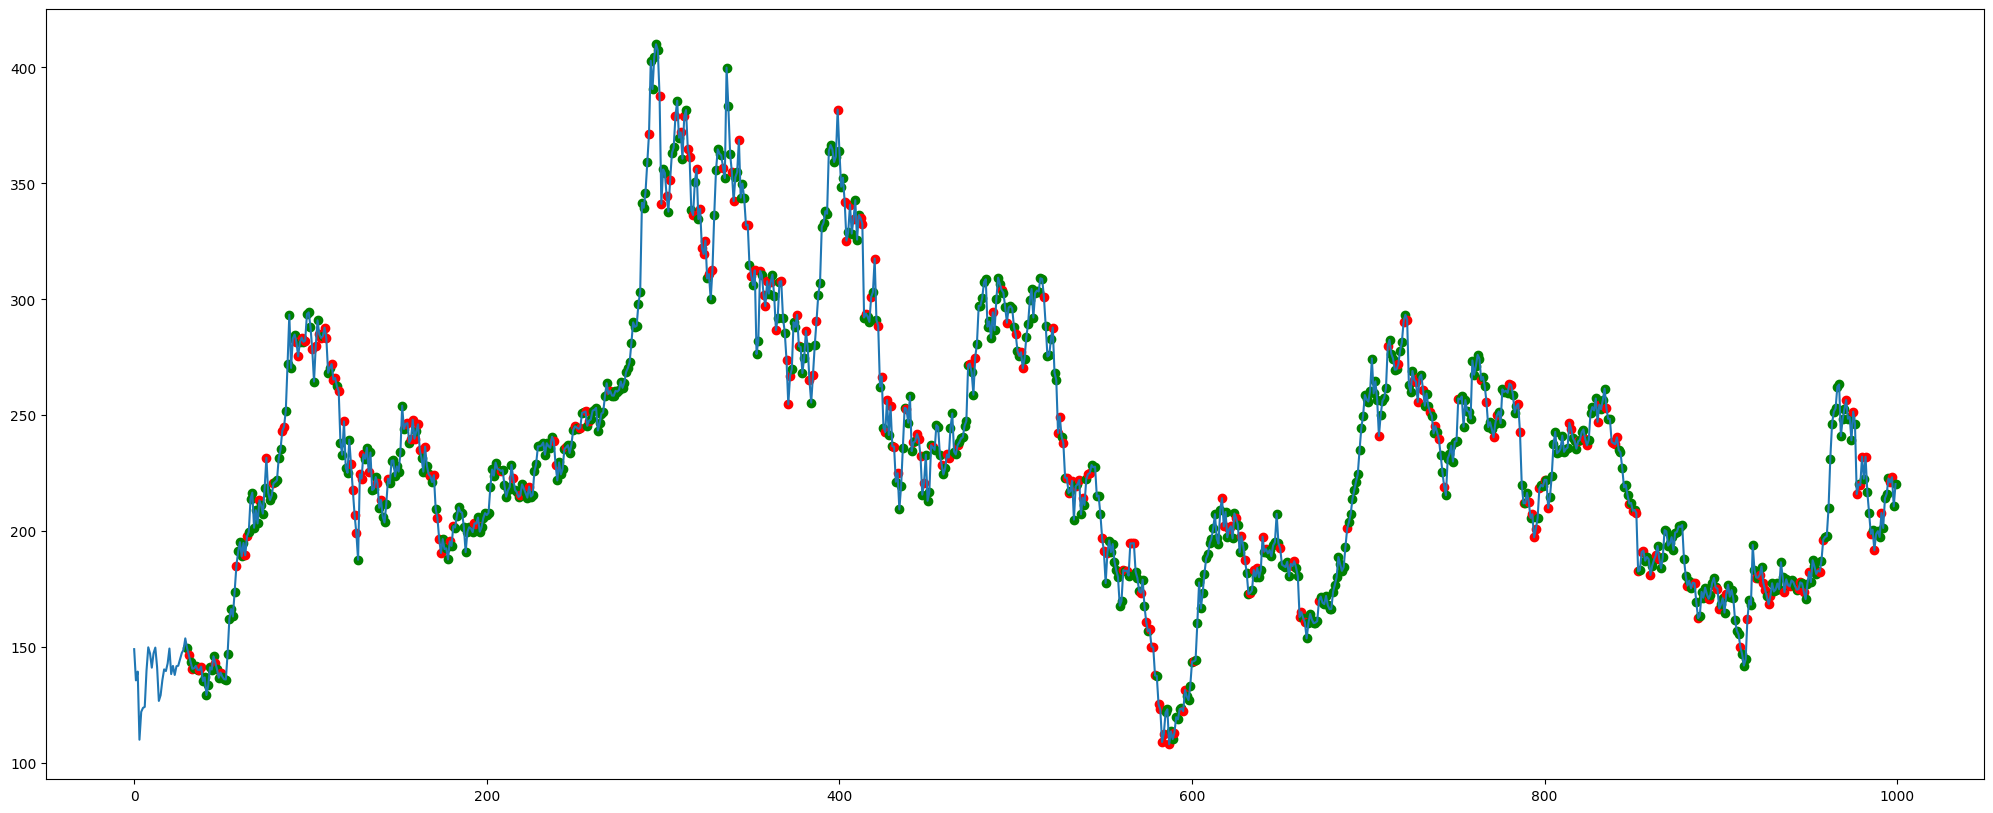

In [ ]:
plt.figure(figsize = (25, 10))
plt.plot(environment.data)
for e, a in enumerate(actions):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data[e], color = 'red')
    else:
        pass
plt.show()

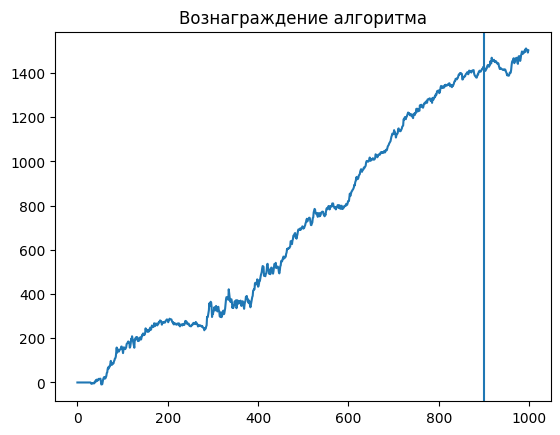

In [ ]:
 # Составляем график доходов. Сделаем фрейм формата Цена/Сигнал
backtest = pd.DataFrame({
    'price': environment.data.flatten(),
    # Первые 5 сигналов отсутствуют, мы должны расширить данные
    # и добавить дополнительные 5 элементов в начало с сигналом 0
    'signal': [0] * WINDOW_SHAPE + actions
})
# Получаем производные цен и делаем сдвиг
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# Суммируем доходы и выводим график
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Вознаграждение алгоритма')

plt.axvline(x=900)
plt.show()